# Evaluation of the model!

We have trained  model using rgdn from this article: https://arxiv.org/pdf/1804.03368.pdf, now let's evalute the results

## 1. Problem

Non blind deconvolution
we have blure image and the kernel that has been used to be blured, we need to get the laten image 
y = k ∗ x + n

* y ∈ R^m : blurred image 
* k ∈ R^l : corresponding blur kernel k
* x ∈ R^n : latent image  
* ∗ denotes the convolution operator
* n ∈ R^m : denotes an i.i.d. white Gaussian noise term with unknown standard deviation (i.e. noise level).

givin y and k, we need to estimate x

k is the psf of an eye of individuals having refractive vision problems. !


## 2. Data

The data we're using till now: *DATASET FROM HRTR: http://chaladze.com/l5/* 

//could be updated later


## 3. Evaluation

The evaluation is **PSNR** and **SSIM** //not commited yet
Now is also visualisation of output photos VS originl photos 'ground truth'
* evaluate our trained model using numbers:
  convolute the recoverd photo (output of our model) with the bluer-kernel and compare it with the input photo to the model (ground-truth*blure-kernel)
   comparing metods to use :MSE, SSIM


## 4. Features

Some information about the data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* We're generating dataset : blur kernel k, and n noise , and then y by ourself   
* 
* . 


In [2]:
#path for dataset folder:
DATA_DIR = "/home/jovyan/Sarasweet/rgdn-optimizer-based-deconvolution/dataFiles/Linnaeus 5 256X256/"

#num_params for psf - for sweet project that makes psf 
num_params=5 # or 20 later! 

#path for already trained models folder:
MODEL_DIR='/home/jovyan/Sarasweet/rgdn-optimizer-based-deconvolution/trainedModels/'

#something for sweet project
SHIFT = True

### Get our workspace ready

* Reload all modules (except those excluded by %aimport) automatically now. '%autoreload'
* Reload all modules (except those excluded by %aimport) every time before executing the Python code typed. '%autoreload 2' ✅
* Import torch=1.10 ✅
* Make sure we're using a GPU ✅
* install lib  pydoe, torchsummary, torchmetrics, piq ✅


In [3]:
%load_ext autoreload
%autoreload 2 

In [4]:
%reload_ext autoreload

In [1]:
# #install necessary tools
# !pip install pydoe -q
# !pip install torchsummary -q
# !pip install torchmetrics -q
# !pip install piq -q


# !pip install torch==1.10 

  Using cached torch-1.10.0-cp36-cp36m-manylinux1_x86_64.whl (881.9 MB)
ERROR: torchvision 0.11.2 has requirement torch==1.10.1, but you'll have torch 1.10.0 which is incompatible.
  Attempting uninstall: torch
    Found existing installation: torch 1.10.1
    Uninstalling torch-1.10.1:
      Successfully uninstalled torch-1.10.1


In [5]:
# Import necessary tools
import torch 

# from __future__ import print_function, absolute_import
import torch
import os
# import scipy.io as sio
from torch.utils.data import Dataset, DataLoader
import numpy as np
# from data.make_kernel import kernel_sim_spline
import matplotlib.pyplot as plt
from sklearn.feature_extraction import image
from pathlib import Path
# from operator import itemgetter
from skimage.color import rgb2gray
import pyDOE as doe # LHS
from scipy.stats.distributions import uniform
from tqdm import tqdm
# from skimage import util, filters
# from scipy import signal

from sweet.sweet import Sweet
from sweet.util.fft import shift, fft_conv

from sklearn.model_selection import train_test_split

#import the NNmodel for our training
from NNmodels.model_rgdn import OptimizerRGDN



print("pytorch version:", torch.__version__)
# 
# Check for GPU availability
print("GPU", "available (YESSSS!!!!!)" if torch.cuda.is_available() else "not available :(")

pytorch version: 1.10.0+cu102
GPU available (YESSSS!!!!!)


## Getting our data ready (turning into Tensors)

With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors (numerical representations).

Let's start by accessing our data and checking out the labels.

In [6]:
#Make our dataset noise variant has been added  


fixed_params = {
    'pupil_diam' : 2.5,
    'A' : 0
}

class BlurryImageDatasetOnTheFlySweet(Dataset):
    '''
    Implemented to use an eye's PSF from Sweet.
    PSF is not cropped.
    Convolution is perfomed with fft_conv.
    '''
    def __init__(self,
                 file_name_list,
                 is_rgb=True,
                 k_size=256,
                 patch_size=256,
                 max_num_images=None,
                 noise_level_interval:tuple =None,
                noise_level:float=None):
        assert is_rgb == False, 'RGB images currently not supported'
        
        self.file_name_list = sorted(file_name_list)
        self.is_rgb = is_rgb
        self.k_size = k_size
        self.patch_size = 256
        self.params = []
        self.num_params = 0
        self.nl=0.0
        self.noise_level_interval=noise_level_interval
        self.noise_level=noise_level

        if max_num_images is not None and max_num_images < len(
                self.file_name_list):
            self.file_name_list = self.file_name_list[:max_num_images]
        
    @staticmethod
    def get_psf(S, A, C, pupil_diam):
        sweet = Sweet()
        sweet.set_eye_prescription(
            S = S,  
            A = A,
            C = C,  
        )
        sweet.set_experiment_params(
            pupil_diam = pupil_diam,  
            view_dist = 100.0,      
            canvas_size_h = 10.0,  
        )
        psf = sweet._psf()
        return psf
    
    
    def params_init(self, params):
        self.params = params
        self.num_params = len(params)
      
        
    def params_random_init(self, num_params): #LHS      
        params = doe.lhs(4, samples=num_params) # order: S, A, C, pupil_diam
        loc =   [-8, fixed_params['A'], -3, fixed_params['pupil_diam']]
        scale = [4,  fixed_params['A'],  3, fixed_params['pupil_diam']]
        for j in range(4):
            if j == 1:
                params[:, j] = fixed_params['A']
            elif j == 3:
                params[:, j] = fixed_params['pupil_diam']
            else:
                params[:, j] = uniform(loc=loc[j], scale=scale[j]).ppf(params[:, j])
        params = params.tolist()
        for i in tqdm(range(num_params)):
            psf = BlurryImageDatasetOnTheFlySweet.get_psf(*params[i])
            psf = psf / psf.sum()        ###### ADD NORMALIZING
            params[i].append(psf)   
        self.params = params
        self.num_params = num_params

        
    def __len__(self):
        return len(self.file_name_list)

    
    def __getitem__(self, idx):
        i = np.random.choice(np.arange(self.num_params))
        k = self.params[i][-1]
        img_name = self.file_name_list[idx]
        sample = plt.imread(img_name)

        if sample.shape[0] < self.patch_size or sample.shape[
                1] < self.patch_size:
            return self.__getitem__((idx - 1) % (self.__len__()))
        patches = image.extract_patches_2d(sample,
                                           [self.patch_size, self.patch_size],
                                           max_patches=1)
        sample = patches[0, ...]
        sample = sample.astype(np.float32) / 255.0
        if not self.is_rgb:
            sample = rgb2gray(sample)
        y = fft_conv(sample, k)
#         print("y:",y.shape)
#         print("k:",k.shape)
#         print('len y',len(y))
#         print('len k',len(k))
        y = torch.tensor(y, dtype=torch.float32).unsqueeze(0)
        
#       #adding noise nl
        self.nl=0.0 #if no noise_level added it will be 0 
        if self.noise_level_interval is not None:
            self.nl = np.random.uniform(self.noise_level_interval[0], self.noise_level_interval[1])  #0.3% - 1.5%
#             print('noise_level_interval {}, {}'.format(self.noise_level_interval[0],self.noise_level_interval[1]))
        elif self.noise_level is not None:
            self.nl = self.noise_level
#             print('noise_level {}'.format(self.noise_level))
            
        y = y + self.nl * torch.randn_like(y)
#         print('nl {}'.format(self.nl))
        
        
        x_gt = torch.tensor(sample, dtype=torch.float32).unsqueeze(0)
        k = torch.tensor(k, dtype=torch.float32).unsqueeze(0)
        kt = torch.flip(k, [1, 2])
        return y, x_gt, k, kt     
    

In [7]:
#make dataset into batches
#load data into batches, as aricle will do in batch of size(4) ! 
#article: https://arxiv.org/pdf/1804.03368.pdf

def get_dataloaders(data_files: list,
                    dataset: torch.utils.data.Dataset,
                    num_params: int,
                    params_filename: str,
                    batch_size:int =4,
                    shuffle:bool=True,
                    drop_last:bool=False,
                    noise_level_interval=None,
                    noise_level=None) -> (torch.utils.data.DataLoader, torch.utils.data.DataLoader):
    """
    Function to get dataloaders (works only with Sweet dataset).
    
    :param: data_files: list with paths to data
    :param: dataset: object of Dataset class
    :param: num_params: number of eye parameters generated on each epoch
    :param: params_filename: name of file to save psf-params generated during the training-sweet project
    :param: batch_size: nefers to the number of training samples used in one iteration
    :param: shuffle: If shuffle is set to True, then all the samples are shuffled and loaded in batches. Otherwise they are sent one-by-one without any shuffling.
    :param: drop_last: drop_last
    :param: tuple (), if noise is a percentage interval (%,%) defult set to None
    :pram: noise_level=float, if noise is fixed a percentage value (for test data) defult set to None

    
    :return: dataloder
    """
    
    files_dataset = dataset(file_name_list=data_files,
                            is_rgb=False,
                            k_size=256,
                            max_num_images=None,
                            noise_level_interval=noise_level_interval,
                            noise_level=noise_level)

    files_dataset.params_random_init(num_params)
    files_dataset.params_init(files_dataset.params)  
    
    data_loader = DataLoader(files_dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)
#     save_params(params_filename, files_dataset)
    
    return data_loader 



#save parameters for seet project
def save_params(filename, dataset):
    with open(filename, 'a') as f:
        for param in dataset.params:
            for p in param:
                f.write(str(p))
                f.write('\n')
            f.write('\n')

In [8]:
# Checkout our data
#How many images we have 

import os
from pathlib import Path
import numpy as np

#path for dataset folder:
# DATA_DIR = "/home/jovyan/Sarasweet/rgdn-optimizer-based-deconvolution/dataFiles/Linnaeus 5 256X256/"


#if train & test files in diffrent folders
train_dir = Path(os.path.join(DATA_DIR, 'train'))
test_dir = Path(os.path.join(DATA_DIR, 'test'))

train_files = list(train_dir.rglob('*.jpg'))
test_files = list(test_dir.rglob('*.jpg'))

print('We have:\nTrain files: {}\nTest files:{}'.format(len(train_files), len(test_files)))


# #if whole dataset (train+test) in same path folders
# data_path=Path(DATA_DIR)
# data_files = list(data_path.rglob('*.jpg'))
# print('We have dataset of {} files, that need to be splited into train and test.\n'.format(len(data_files)))


#train_files[:5]


We have:
Train files: 6000
Test files:2000


In [9]:
#load our saved model - need to be edited later

def load_trained_model(model: torch.nn.Module, 
                       opt: torch.optim.Optimizer,
                       name: str) -> (torch.nn.Module, torch.optim):  
    """
    :param model: pytorch model to save
    :param opt: optimizer
    :param: model_name: name of the file where the model is stored
    :return: model with pretrained weights, optimizer
    """
    
    optimizer=opt
    path = MODEL_DIR + name
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return model, optimizer

In [10]:
#evalute our model



#initiate optimizer and a model 
rgdn = OptimizerRGDN(num_steps=5, is_rgb=False)
# optimizer = torch.optim.Optimizer()
optimizer = torch.optim.Adam(rgdn.parameters(), lr=5e-5)

#load the model
model, optimizer=load_trained_model(model=rgdn,
                                     opt=optimizer,
                                     name='RGDN-SWEET-normed-param-d-GRAY-FFT-todel-after-server-crashed-noise-added-70')


# Evaluation

## Compare Two Images 

Evaluate our trained model using numbers: convolute the recoverd photo (output of our model) with the bluer-kernel and compare it with the input photo to the model (ground-truth*blure-kernel) comparing metods to use :MSE, SSIM



Mean Squared Error (MSE) between two mages I, K:

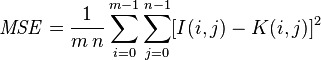


Structural Similarity Index (SSIM):

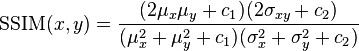

(x, y) location of the N x N window in each image, the mean of the pixel intensities in the x and y direction, the variance of intensities in the x and y direction, along with the covariance.

Unlike MSE, the SSIM value can vary between -1 and 1, where 1 indicates perfect similarity.

In [11]:
def mse(imageA, imageB):

    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])

    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err


# import the necessary packages
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import numpy as np
# import cv2

def compare_images(imageA, imageB, title):
    # compute the mean squared error and structural similarity
    # index for the images
    m = mse(imageA, imageB)
    s = ssim(imageA, imageB)
    # setup the figure
    fig = plt.figure(title)
    plt.suptitle("MSE: %.2f, SSIM: %.4f" % (m, s))
    # show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(imageA, cmap = 'gray')
    plt.axis("off")
    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(imageB, cmap = 'gray')
    plt.axis("off")
    # show the images
    plt.show()

In [18]:
test_loader = get_dataloaders(data_files=test_files[:100],
                               dataset=BlurryImageDatasetOnTheFlySweet,
                               num_params=num_params,
                               batch_size=4,
                               shuffle=False,
                               drop_last=False,
                               params_filename="file_to_save_parm_psf",
                               noise_level_interval=(0.003,0.015),
                               noise_level=None)



100%|██████████| 5/5 [00:00<00:00,  6.48it/s]


In [19]:
#function from tensor to numpy 

def data_to_numpy(y, x_gt, k, kt) -> (np.array,np.array,np.array,np.array):  
    """
    return images in numpy array from dataset tensor.
    
    :param y: y-blurred image (x_gt*k)
    :param x_gt: x_ground truth
    :param: k: blur-kernel
    :param: kt: transpose of blur kernel
    :return: the same images as numpy array.
    """
    n_imgs=len(y)
    
    k_np=[]
    kt_np=[]
    y_np=[]
    x_gt_np=[]

    for id_img in range(n_imgs):
        #turn all to numpy array from tensors
        k_np.append(k[id_img].squeeze(0).cpu().numpy())
        y_np.append(y[id_img][0, :, :].cpu().numpy())
        x_gt_np.append(x_gt[id_img][0, :, :].cpu().numpy())
        kt_np.append(kt[id_img].squeeze(0).cpu().numpy())
    
    return y_np,x_gt_np,k_np,kt_np

def out_model_to_numpy(res)->(np.array):
    """
    return image in numpy array from output image tensor from model.
    :param res: output image tensor from model
    :return: the same image as numpy array.
    """
    
    n_imgs=len(res)
    x_hat=[]
    
    for id_img in range(n_imgs-1):
        x_hat.append(res[-1][id_img].detach().cpu().squeeze(0).numpy())
        
    return x_hat

    


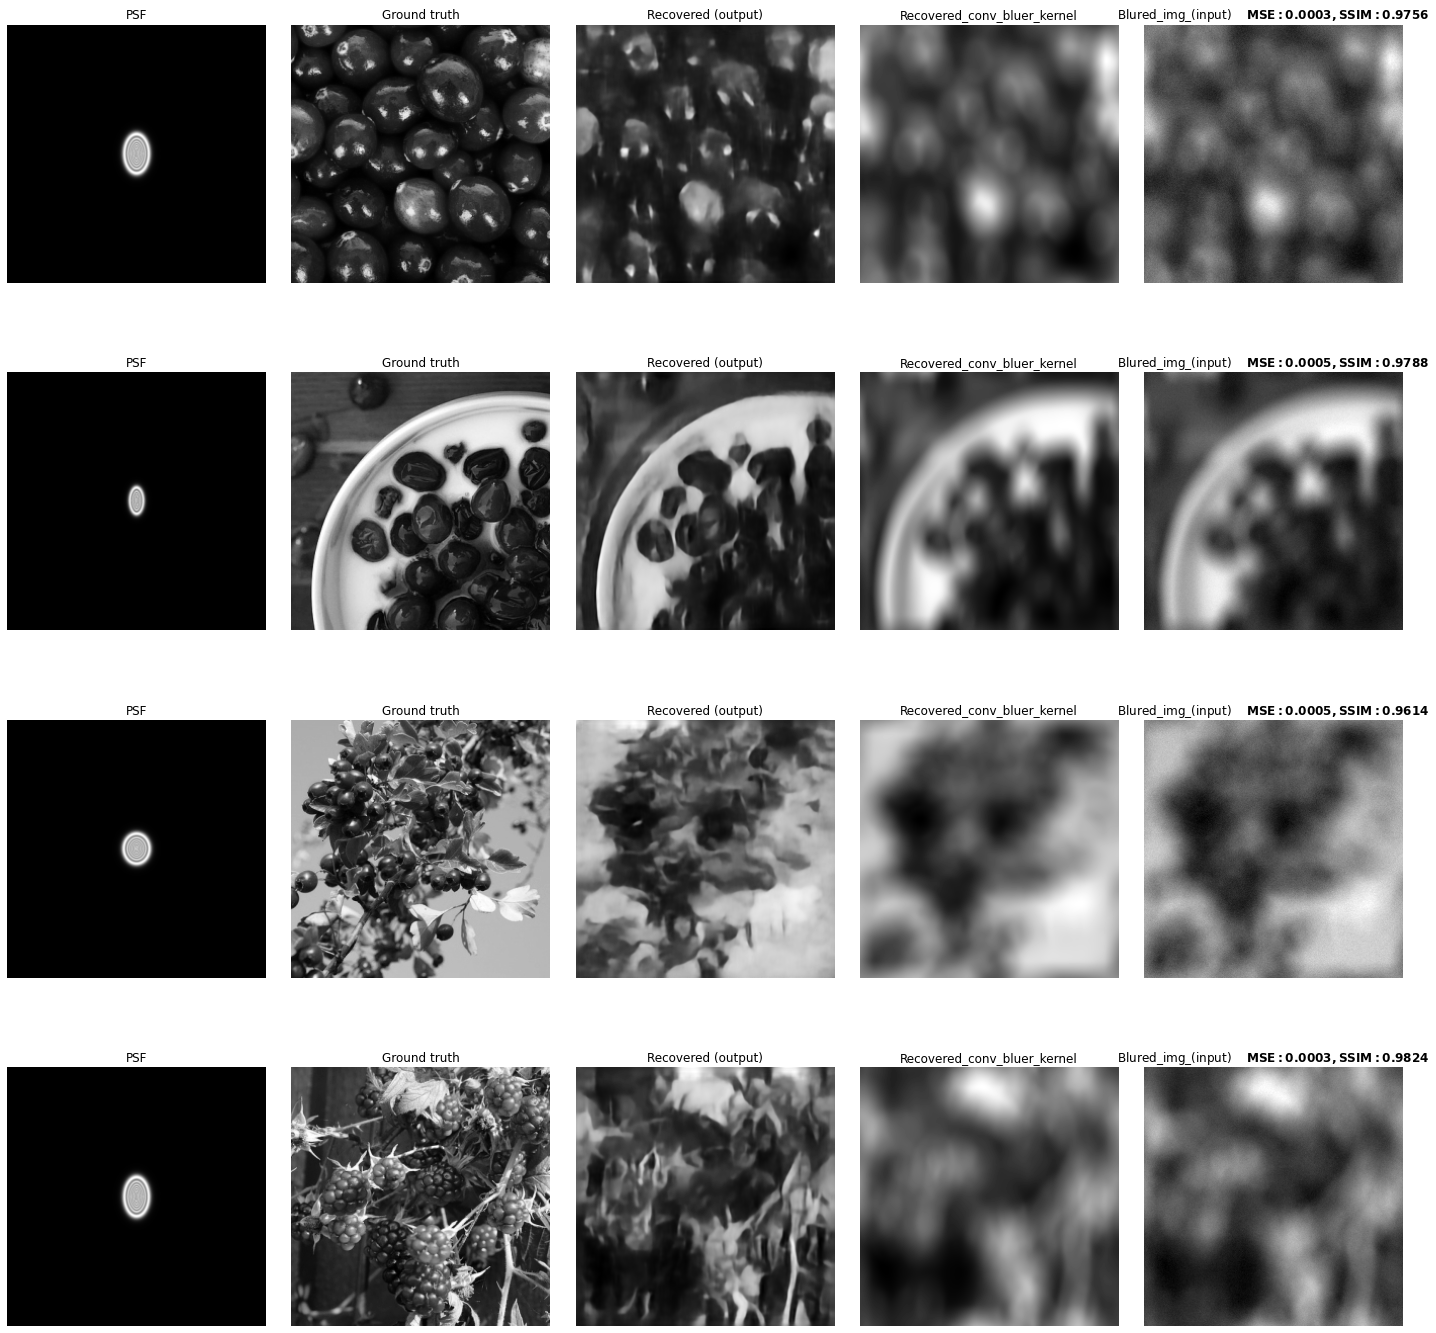

In [65]:
#Test the first batch 

# get the next iteration of dataset sample
y, x_gt, k, kt = next(iter(test_loader))

#get the recoverd photo from our model
res = model(y, k, kt)

#from tensor to numpy
x_hat=out_model_to_numpy(res)
y_np,x_gt_np,k_np,kt_np=data_to_numpy(y,x_gt,k,kt)


n_imgs=len(y)
figsize: tuple=(25, 25)
fig, axs = plt.subplots(nrows=n_imgs, ncols=5, figsize=figsize)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.1)
   
for id_img in range(n_imgs):
    
            #turn off axis number
            for i in range(5):
                axs[id_img][i].axis('off')
                
            #convolute the recovered photo with blure-kernel    
            res_conv_k= fft_conv(x_hat[id_img], k_np[id_img])
            #unite the datatype
            res_conv_k=res_conv_k.astype(np.float32)
            m = mse(res_conv_k, y_np[id_img])
#             m = mse(x_gt_np[id_img], y_np[id_img])
            s = ssim(res_conv_k, y_np[id_img])
            
#             compare_images(res_conv_k, y_np, "input to model vs. output*K")
            
            # better visualization psf-shift
            if SHIFT:
                kj = shift(k_np[id_img])
            else:
                kj = k_np[id_img[id_img]]
            
            #plot the images    
            axs[id_img][0].imshow(kj, cmap='gray')
            axs[id_img][0].set_title("PSF")

            axs[id_img][1].imshow(x_gt_np[id_img], cmap='gray')
            axs[id_img][1].set_title("Ground truth")
            
            axs[id_img][2].imshow(x_hat[id_img], cmap='gray')
            axs[id_img][2].set_title("Recovered (output)")

            axs[id_img][3].imshow(res_conv_k, cmap='gray')
            axs[id_img][3].set_title("Recovered_conv_bluer_kernel")

            axs[id_img][4].imshow(y_np[id_img], cmap='gray')
            axs[id_img][4].set_title("Blured_img_(input)    "+ r"$\bf{" +("MSE: %.4f, SSIM: %.4f" % (m, s))+ "}$")
            
           


### Let's first see what is MSE and SSIM for ground_truth image and blurred_image 

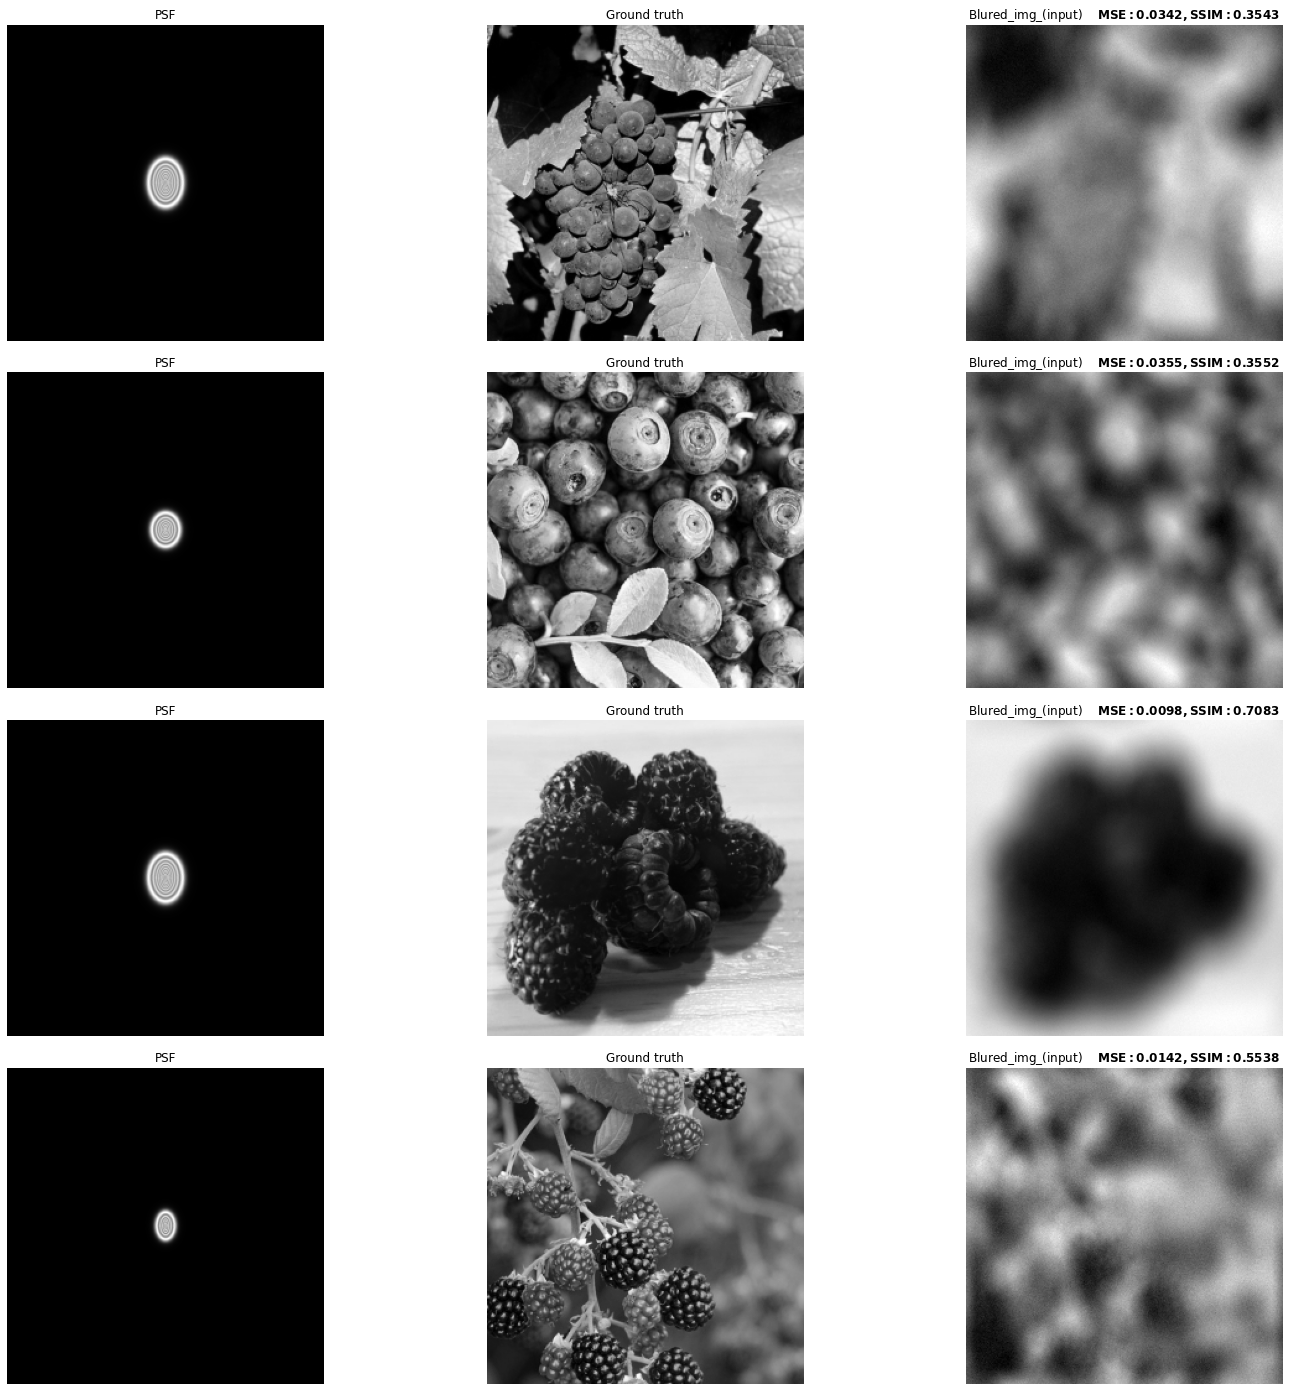

In [27]:
figsize: tuple=(25, 25)
fig, axs = plt.subplots(nrows=n_imgs, ncols=3, figsize=figsize)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.1)
for id_img in range(n_imgs):
    
    for i in range(3):
        axs[id_img][i].axis('off')
    res_conv_k= fft_conv(x_hat[id_img], k_np[id_img])
    res_conv_k=res_conv_k.astype(np.float32)
    m = mse(x_gt_np[id_img], y_np[id_img])
#             m = mse(x_gt_np[id_img], y_np[id_img])
    s = ssim(x_gt_np[id_img], y_np[id_img])

    # better visualization psf-shift
    if SHIFT:
        kj = shift(k_np[id_img])
    else:
        kj = k_np[id_img[id_img]]

    #plot the images    
    axs[id_img][0].imshow(kj, cmap='gray')
    axs[id_img][0].set_title("PSF")

    axs[id_img][1].imshow(x_gt_np[id_img], cmap='gray')
    axs[id_img][1].set_title("Ground truth")

    axs[id_img][2].imshow(y_np[id_img], cmap='gray')
    axs[id_img][2].set_title("Blured_img_(input)    "+ r"$\bf{" +("MSE: %.4f, SSIM: %.4f" % (m, s))+ "}$")

           
            
            
      

In [20]:
import pandas as pd
 
            
# create an Empty pandas DataFrame 
df = pd.DataFrame()
# print("SSIM & MSE between Ground_Truth image and blurred image ")
# append data in columns to an empty pandas DataFrame
df['MSE(GT,blurred)'] = []
df['MSE(Res*K, blurred)'] = []
df['SSIM(GT,blurred)'] = []
df['SSIM(Res*K, blurred)'] = []


#from tensor to numpy

for y, x_gt, k, kt in tqdm(test_loader):
    res=model(y,k,kt)
    x_hat=out_model_to_numpy(res)
    y_np,x_gt_np,k_np,kt_np=data_to_numpy(y,x_gt,k,kt)

    n_imgs=len(y)

    for id_img in range(n_imgs):              

        #recoverd img convoluted with the blur kernel K
        res_conv_k= fft_conv(x_hat[id_img], k_np[id_img])
        #unite datatupe 
        res_conv_k=res_conv_k.astype(np.float32)

        #calculate MSE and SSIM between ground_truth and blurred image    
        mgt = mse(x_gt_np[id_img], y_np[id_img])
        sgt = ssim(x_gt_np[id_img], y_np[id_img])

        #calculate MSE and SSIM between recoverd img convoluted with the blur kernel K and blurred image            
        mrk = mse(res_conv_k, y_np[id_img])
        srk = ssim(res_conv_k, y_np[id_img]) 

        #add the result to our data frame 
        df=df.append({'MSE(GT,blurred)' : mgt, 'SSIM(GT,blurred)': sgt,
                      'MSE(Res*K, blurred)': mrk,
                     'SSIM(Res*K, blurred)': srk}, 
                    ignore_index = True)

#         compare_images(x_gt_np[id_img],y_np[id_img], "input to model vs. output*K")
              
df


100%|██████████| 25/25 [10:32<00:00, 25.29s/it]


,"MSE(GT,blurred)","MSE(Res*K, blurred)","SSIM(GT,blurred)","SSIM(Res*K, blurred)"
0,0.020172,0.000679,0.582051,0.955681
1,0.010236,0.000289,0.680241,0.953244
2,0.020610,0.000280,0.304300,0.990481
3,0.003647,0.000151,0.825434,0.993842
4,0.011122,0.000488,0.526454,0.975869
...,...,...,...,...
95,0.045438,0.000944,0.310302,0.962804
96,0.034207,0.000768,0.354259,0.963087
97,0.035451,0.000526,0.355210,0.974487
98,0.009770,0.000377,0.708305,0.991484


In [24]:
dfMean=df.mean()
dfMean

MSE(GT,blurred)         0.016437
MSE(Res*K, blurred)     0.000639
SSIM(GT,blurred)        0.558325
SSIM(Res*K, blurred)    0.968416
dtype: float64